### Surface Velocity and Discharge Estimation using FlowFormer++

This code estimates river surface velocity from video imagery using the FlowFormer++ deep optical flow model and computes discharge by combining the resulting velocities with surveyed bathymetry and water stage data.

In [2]:
import os
print(os.getcwd())

/workspace


In [3]:
os.chdir("/workspace/FlowFormerPlusPlus")
print("Now in:", os.getcwd())

Now in: /workspace/FlowFormerPlusPlus


### 1). Surface Velocity Estimation

Using device: cuda:0
Loading FlowFormer++ model...
[Using larger cost as gt, radius is 15]
[Decoder flow_or_pe setting is: and]
[Using GMA]
✅ FlowFormer++ model loaded successfully.
Loaded 48 survey points

🚀 Running model: FlowFormer++
Computing flow across 9 frame pairs using FlowFormer++...


FlowFormer++ flow:   0%|          | 0/9 [00:00<?, ?pair/s]

/workspace/miniconda/envs/flowformerpp/lib/python3.9/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


✅ Flow computation complete in 14.4s for FlowFormer++
✅ Saved cross-section CSV (survey points): results/flowformer/FlowFormer++/May13_2025/May13_2025_cross_section_survey_points.csv
📊 Velocity range: 0.000 to 2.905 m/s
✅ Saved single image: results/flowformer/FlowFormer++/May13_2025/May13_2025_roi_vectors_with_cross_section.png
✅ Saved subplot 1: results/flowformer/FlowFormer++/May13_2025/May13_2025_subplot_1.png
✅ Saved subplot 2: results/flowformer/FlowFormer++/May13_2025/May13_2025_subplot_2.png
✅ Saved subplot 3: results/flowformer/FlowFormer++/May13_2025/May13_2025_subplot_3.png
✅ Saved subplot 4: results/flowformer/FlowFormer++/May13_2025/May13_2025_subplot_4.png
✅ Saved subplot 5: results/flowformer/FlowFormer++/May13_2025/May13_2025_subplot_5.png


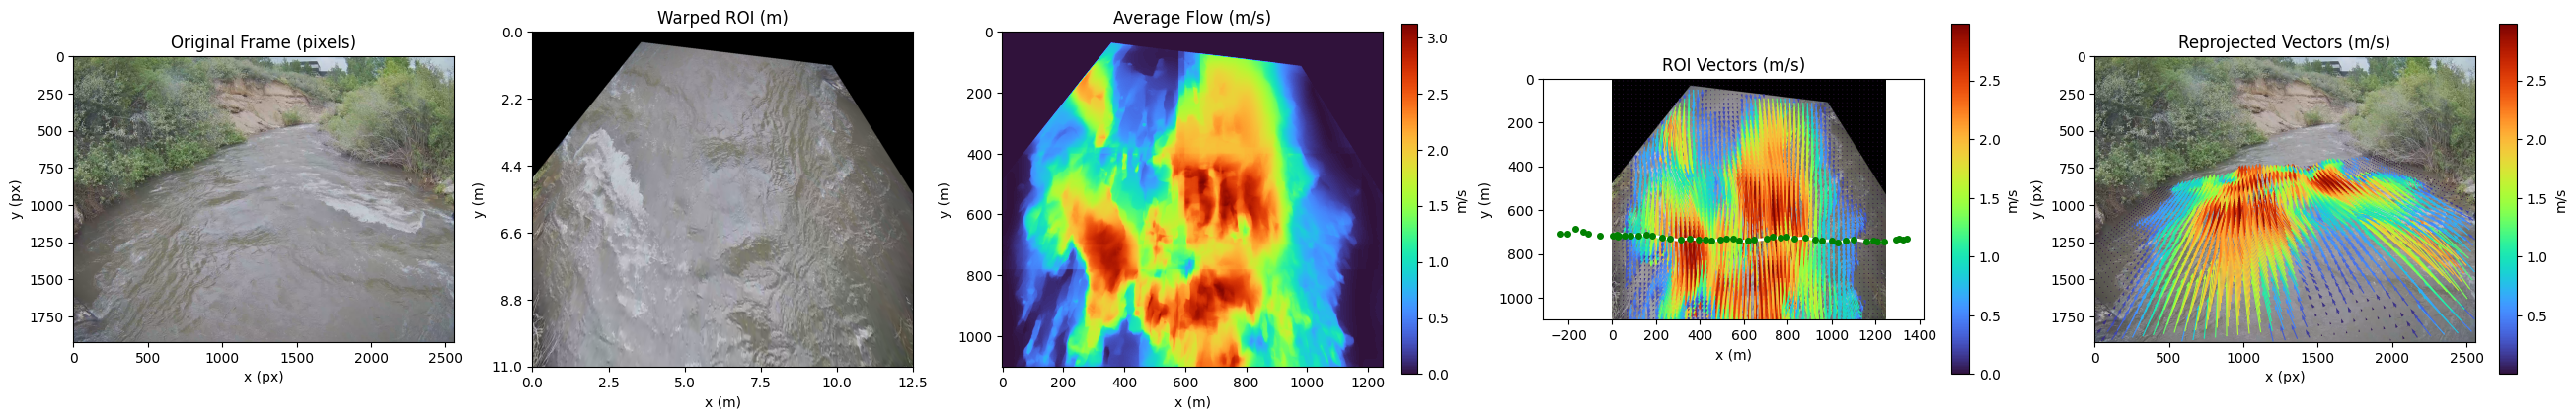

✅ Saved summary CSV: results/flowformer/FlowFormer++/May13_2025/May13_2025_summary.csv

✅ FLOWFORMER++ PROCESSING COMPLETE!
📁 Output directory: results/flowformer/FlowFormer++/May13_2025
📊 Velocity CSV: results/flowformer/FlowFormer++/May13_2025/May13_2025_cross_section_survey_points.csv
📈 Summary stats: results/flowformer/FlowFormer++/May13_2025/May13_2025_summary.csv
🖼️  Visualizations saved as PNG files
All done.


In [4]:
# ========================================
# FLOWFORMER++ RIVER VELOCITY ANALYSIS
# ========================================
# This script processes river monitoring video to compute surface water
# velocities using FlowFormer++ optical flow algorithm.
# 
# Key Features:
# - Video stabilization via homography
# - Optical flow computation using FlowFormer++ (state-of-the-art transformer-based model)
# - Velocity interpolation at surveyed coordinates
# - Multi-panel visualization output
# ========================================

import os
import math
import time
import gc
import subprocess
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt
import sys
from tqdm.auto import tqdm
from scipy.interpolate import griddata, interp1d

# FlowFormer++ imports (from your repository)
sys.path.append('core')
from configs.submissions import get_cfg
from core.FlowFormer import build_flowformer

# ========================================
# SECTION 1: CONFIGURATION SETTINGS
# ========================================
VIDEO_PATH = "May13_2025.mp4"          # Your river monitoring video
NUM_FRAMES = 10                        # Number of frames to process
USE_GPU = True                         # Enable GPU acceleration if available
STEP = 20                              # Vector subsampling (higher = fewer arrows)
PIXEL_TO_M = 0.01                      # Calibration: 1 pixel = 1 cm (adjust for your camera configuration)
FPS = 30                               # Video frame rate (check your camera settings)
SCALE = PIXEL_TO_M * FPS * 100         # px/frame → cm/s (kept to match original MaskFlowNet)
OUT_ROOT = "results/flowformer"        # Root output folder for FlowFormer++ results

#Cross section profile surveyed
CSV_FILE = "UWRL_Survey_Updated.csv"  # The cross section you want to get surface velocity at

# FlowFormer++ specific settings
TRAIN_SIZE = [400, 600]                # FlowFormer++ patch size for tiled inference
CHECKPOINT = "FlowFormer_checkpoints/checkpoints/sintel.pth"  # FlowFormer++ pretrained model

# Device selection (automatic fallback to CPU if GPU unavailable)
DEVICE = torch.device('cuda:0' if USE_GPU and torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# ========================================
# SECTION 2: PERSPECTIVE CORRECTION (Homography)
# ========================================
# Because our camera isn't perfectly perpendicular to the water surface,
# we apply a homography transform to get a true top-down view.
# These points map distorted image coordinates to real-world coordinates.
# IMPORTANT: Calibrate these points for YOUR camera setup!

# Source points in the original image (minimum 4 needed)
src_points = np.array([
    [105, 1770], [140, 1060], [2499, 820], [2223, 708],
    [210, 1420], [662, 854], [2450, 1280], [2250, 900]
], dtype=np.float32)

# Destination points in the corrected view (real-world coordinates)
dst_points = np.array([
    [1286.8, 295.1], [1552.7, 821.8], [236.5, 682.3], [222.6, 1003.8],
    [1389.0, 542.1], [1349.1, 1310.7], [503.5, 411.3], [331.7, 811.9]
], dtype=np.float32)

# Compute the homography matrix and its inverse
H, _ = cv2.findHomography(src_points, dst_points)
H_inv = np.linalg.inv(H)

# ========================================
# SECTION 3: REGION OF INTEREST (ROI) SELECTION
# ========================================
# We focus only on the water surface area to avoid noise from banks/vegetation.
# For our site, this ROI covers the main channel where we have survey points.

roi_points = np.array([
    [400, 150],
    [1550, 250],
    [300, 1000],
    [1550, 1250]
], dtype=np.int32)

x_min, y_min = int(np.min(roi_points[:,0])), int(np.min(roi_points[:,1]))
x_max, y_max = int(np.max(roi_points[:,0])), int(np.max(roi_points[:,1]))

# ========================================
# SECTION 4: HELPER FUNCTIONS
# ========================================
# These functions handle the core processing steps and are identical to MaskFlowNet.

def warp_frame(frame, H, warp_size=(2560, 1920)):
    """Apply perspective correction to a frame"""
    return cv2.warpPerspective(frame, H, warp_size)

def crop_roi(frame, roi_pts):
    """Extract the Region of Interest from a frame"""
    x_min_, y_min_ = int(np.min(roi_pts[:,0])), int(np.min(roi_pts[:,1]))
    x_max_, y_max_ = int(np.max(roi_pts[:,0])), int(np.max(roi_pts[:,1]))
    return frame[y_min_:y_max_, x_min_:x_max_], (x_min_, y_min_, x_max_, y_max_)

def erode_mask(mask, ksize=5):
    """Clean up the mask edges to remove noise"""
    kernel = np.ones((ksize,ksize), np.uint8)
    return cv2.erode(mask.astype(np.uint8), kernel, iterations=1)

def block_average(flow, step):
    """Average flow vectors over blocks for cleaner visualization"""
    Hf, Wf, _ = flow.shape
    dx_avg = np.zeros((Hf//step, Wf//step), dtype=np.float32)
    dy_avg = np.zeros((Hf//step, Wf//step), dtype=np.float32)
    speed_avg = np.zeros((Hf//step, Wf//step), dtype=np.float32)
    
    for i in range(0, Hf-step+1, step):
        for j in range(0, Wf-step+1, step):
            block = flow[i:i+step, j:j+step, :]
            dx_avg[i//step, j//step] = np.mean(block[...,0])
            dy_avg[i//step, j//step] = np.mean(block[...,1])
            speed_avg[i//step, j//step] = np.sqrt(np.mean(block[...,0])**2 + np.mean(block[...,1])**2)
    
    return dx_avg, dy_avg, speed_avg

# ========================================
# SECTION 5: FLOWFORMER++ SPECIFIC FUNCTIONS
# ========================================
# These functions handle FlowFormer++ specific operations like tiled inference
# and weight computation for seamless patch stitching.

def compute_grid_indices(image_shape, patch_size=TRAIN_SIZE, min_overlap=20):
    """Compute grid indices for tiled inference to handle large images"""
    hs = list(range(0, image_shape[0], patch_size[0]-min_overlap)) if image_shape[0] != patch_size[0] else [0]
    ws = list(range(0, image_shape[1], patch_size[1]-min_overlap)) if image_shape[1] != patch_size[1] else [0]
    
    hs[-1] = image_shape[0] - patch_size[0]
    ws[-1] = image_shape[1] - patch_size[1]
    
    return [(h,w) for h in hs for w in ws]

def compute_weight(hws, image_shape, patch_size=TRAIN_SIZE, sigma=1.0):
    """Compute Gaussian weights for seamless patch stitching"""
    h, w = torch.meshgrid(torch.arange(patch_size[0], device=DEVICE),
                          torch.arange(patch_size[1], device=DEVICE),
                          indexing='ij')
    
    h = (h - patch_size[0]/2)/patch_size[0]
    w = (w - patch_size[1]/2)/patch_size[1]
    weights_hw = torch.exp(-0.5*(h**2 + w**2)/sigma**2)/(sigma*math.sqrt(2*math.pi))
    
    weights = torch.zeros(1, len(hws), *image_shape, device=DEVICE)
    for idx, (h0, w0) in enumerate(hws):
        weights[:, idx, h0:h0+patch_size[0], w0:w0+patch_size[1]] = weights_hw
    
    return [weights[:, idx:idx+1, h0:h0+patch_size[0], w0:w0+patch_size[1]] for idx,(h0,w0) in enumerate(hws)]

def compute_flow_flowformer(model, img1_t, img2_t):
    """Compute optical flow using FlowFormer++ with tiled inference"""
    img1 = img1_t.unsqueeze(0).to(DEVICE)
    img2 = img2_t.unsqueeze(0).to(DEVICE)
    H_img, W_img = img1.shape[2], img1.shape[3]
    
    hws = compute_grid_indices((H_img, W_img))
    weights = compute_weight(hws, (H_img, W_img))
    
    flows = torch.zeros(1, 2, H_img, W_img, device=DEVICE)
    flow_count = torch.zeros(1, 1, H_img, W_img, device=DEVICE)
    
    with torch.no_grad():
        for idx, (h, w) in enumerate(hws):
            tile1 = img1[:,:,h:h+TRAIN_SIZE[0], w:w+TRAIN_SIZE[1]]
            tile2 = img2[:,:,h:h+TRAIN_SIZE[0], w:w+TRAIN_SIZE[1]]
            flow_tile, _ = model(tile1, tile2)
            
            pad = (w, W_img-w-TRAIN_SIZE[1], h, H_img-h-TRAIN_SIZE[0], 0, 0)
            flows += F.pad(flow_tile * weights[idx], pad)
            flow_count += F.pad(weights[idx], pad)
            
            torch.cuda.empty_cache()
    
    flow = (flows / flow_count)[0].permute(1,2,0).cpu().numpy()
    return flow

def prepare_image_torch(frame_roi):
    """Prepare ROI frame for FlowFormer++ inference"""
    im = np.array(frame_roi)[:,:,:3].astype(np.uint8)
    t = torch.from_numpy(im).permute(2,0,1).float()
    return t

# ========================================
# SECTION 6: FLOWFORMER++ MODEL SETUP
# ========================================
# We're using FlowFormer++ for flow estimation. This is a state-of-the-art
# transformer-based optical flow model that achieves excellent accuracy.
# Note: The model checkpoint should be downloaded separately.

print("Loading FlowFormer++ model...")
cfg = get_cfg()
flow_model = torch.nn.DataParallel(build_flowformer(cfg))
ckpt = torch.load(CHECKPOINT, map_location=DEVICE)
flow_model.load_state_dict(ckpt)
flow_model.to(DEVICE).eval()
print("✅ FlowFormer++ model loaded successfully.")

# ========================================
# SECTION 7: VIDEO LOADING
# ========================================
# Load and preprocess the video frames for analysis

cap = cv2.VideoCapture(VIDEO_PATH)
if not cap.isOpened():
    raise IOError(f"Could not open video: {VIDEO_PATH}")

frames = []
for i in range(NUM_FRAMES):
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
cap.release()

if len(frames) < 2:
    raise RuntimeError("Need at least 2 frames to compute flow.")

video_name = os.path.splitext(os.path.basename(VIDEO_PATH))[0]

# ========================================
# SECTION 8: SURVEY DATA LOADING
# ========================================
# Load GPS survey points where we want velocity measurements.
# These are the exact locations where field measurements were taken.


df = pd.read_csv(CSV_FILE)
df.columns = df.columns.str.strip()

# Find the relevant columns (handles different naming conventions)
north_col = None
east_col = None
elev_col = None

for c in df.columns:
    cl = c.lower().replace(' ', '').replace('(', '').replace(')', '')
    if 'north' in cl or ('*northing' in cl) or (cl == 'n' and north_col is None):
        north_col = c
    if 'east' in cl or ('*easting' in cl) or (cl == 'e' and east_col is None):
        east_col = c
    if 'elev' in cl or 'elevation' in cl or 'height' in cl:
        elev_col = c

# Fallback to exact column names from our survey data
if north_col is None and '*Northing(m)' in df.columns:
    north_col = '*Northing(m)'
if east_col is None and '*Easting(m)' in df.columns:
    east_col = '*Easting(m)'

if north_col is None or east_col is None:
    raise RuntimeError("Cannot detect Northing/Easting columns in Survey.csv. Please ensure headers include 'Northing' and 'Easting' or '*Northing(m)' and '*Easting(m)'.")

if elev_col is None:
    # No elevation data - create zero column but maintain structure
    df['Elevation'] = 0.0
    elev_col = 'Elevation'
    print("Warning: No elevation column detected; creating Elevation = 0.0 column for output.")

# Build clean dataframe with standardized column names
survey_df = df[[north_col, east_col, elev_col]].rename(columns={
    north_col: 'Northing',
    east_col: 'Easting',
    elev_col: 'Elevation'
}).copy()

survey_df['Northing'] = pd.to_numeric(survey_df['Northing'], errors='coerce')
survey_df['Easting'] = pd.to_numeric(survey_df['Easting'], errors='coerce')
survey_df['Elevation'] = pd.to_numeric(survey_df['Elevation'], errors='coerce')
survey_df = survey_df.dropna(subset=['Northing','Easting']).reset_index(drop=True)

print(f"Loaded {len(survey_df)} survey points")

# ========================================
# SECTION 9: MAIN PROCESSING LOOP
# ========================================
# This is where the optical flow magic happens!
# We process each frame pair and accumulate flow information using FlowFormer++.

model_name = "FlowFormer++"
print(f"\n🚀 Running model: {model_name}")

model_out_dir = os.path.join(OUT_ROOT, model_name, video_name)
os.makedirs(model_out_dir, exist_ok=True)

# Flow computation across frame pairs
flow_sum, valid_sum = None, None
total_pairs = len(frames) - 1
start_time = time.time()

print(f"Computing flow across {total_pairs} frame pairs using FlowFormer++...")

# Process each consecutive frame pair
for i in tqdm(range(total_pairs), desc=f"{model_name} flow", unit="pair"):
    img1, img2 = frames[i], frames[i+1]
    
    # Apply perspective correction
    warped1, warped2 = warp_frame(img1, H), warp_frame(img2, H)
    
    # Extract Region of Interest
    roi1, _ = crop_roi(warped1, roi_points)
    roi2, _ = crop_roi(warped2, roi_points)
    
    # Create mask to ignore non-water areas
    mask = np.any(roi1 > 0, axis=-1).astype(np.float32)
    mask = erode_mask(mask, ksize=5).astype(np.float32)
    
    # Compute optical flow with FlowFormer++
    try:
        t1 = prepare_image_torch(roi1).to(DEVICE)
        t2 = prepare_image_torch(roi2).to(DEVICE)
        flow = compute_flow_flowformer(flow_model, t1, t2)
    except RuntimeError as e:
        print(f"⚠ RuntimeError at frame {i+1}: {e}")
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()
        
        # Fallback to CPU if needed
        model_cpu = flow_model.cpu()
        t1_cpu = prepare_image_torch(roi1).cpu()
        t2_cpu = prepare_image_torch(roi2).cpu()
        flow = compute_flow_flowformer(model_cpu, t1_cpu, t2_cpu)
        
        if DEVICE != torch.device('cpu') and torch.cuda.is_available():
            flow_model.to(DEVICE)
    
    # Apply mask and accumulate
    flow = flow * mask[..., None]
    
    if flow_sum is None:
        flow_sum = np.zeros_like(flow, dtype=np.float32)
        valid_sum = np.zeros(mask.shape, dtype=np.float32)
    
    flow_sum += flow
    valid_sum += mask

elapsed = time.time() - start_time
print(f"✅ Flow computation complete in {elapsed:.1f}s for {model_name}")

# ========================================
# SECTION 10: VELOCITY CALCULATION
# ========================================
# Convert pixel flow to real-world velocities

valid_sum[valid_sum == 0] = 1
avg_flow = flow_sum / valid_sum[..., None]  # px/frame
avg_vel_px = np.sqrt(avg_flow[...,0]**2 + avg_flow[...,1]**2)
avg_vel_cm = avg_vel_px * SCALE  # cm/s

vmax_cm = np.percentile(avg_vel_cm, 99)
mean_vel_cm = np.nanmean(avg_vel_cm[avg_vel_cm > 0]) if np.any(avg_vel_cm > 0) else 0.0

# Block averaging for cleaner vector visualization
dx_block, dy_block, speed_block = block_average(avg_flow * SCALE, STEP)  # speed_block in cm/s

yy, xx = np.mgrid[0:dx_block.shape[0], 0:dx_block.shape[1]]
points_grid_px = np.stack([xx.ravel() * STEP + STEP//2, yy.ravel() * STEP + STEP//2], axis=-1)
vel_values_cm = speed_block.ravel()

# Get ROI frame for visualization
roi_frame, _ = crop_roi(warp_frame(frames[0], H), roi_points)
h_roi_px, w_roi_px = roi_frame.shape[:2]

x_min_m = x_min * PIXEL_TO_M
y_min_m = y_min * PIXEL_TO_M

# ========================================
# SECTION 11: REPROJECTION TO ORIGINAL VIEW
# ========================================
# Convert ROI vectors back to original image coordinates for visualization

start_pts_roi = np.stack([xx*STEP+STEP//2+x_min, yy*STEP+STEP//2+y_min], axis=-1).reshape(-1,2).astype(np.float32)
end_pts_roi = start_pts_roi + np.stack([dx_block, dy_block], axis=-1).reshape(-1,2).astype(np.float32)

start_pts_orig = cv2.perspectiveTransform(start_pts_roi[None,:,:].astype(np.float32), H_inv)[0]
end_pts_orig = cv2.perspectiveTransform(end_pts_roi[None,:,:].astype(np.float32), H_inv)[0]

dx_o = end_pts_orig[:,0] - start_pts_orig[:,0]
dy_o = end_pts_orig[:,1] - start_pts_orig[:,1]
speed_color = speed_block.ravel()

h0, w0 = frames[0].shape[:2]
inside = (start_pts_orig[:,0]>=0)&(start_pts_orig[:,0]<w0)&(start_pts_orig[:,1]>=0)&(start_pts_orig[:,1]<h0)

sx, sy, dx_o_disp, dy_o_disp, speed_color_disp = start_pts_orig[inside,0], start_pts_orig[inside,1], dx_o[inside], dy_o[inside], speed_color[inside]

# ========================================
# SECTION 12: CROSS-SECTION INTERPOLATION
# ========================================
# Create a smooth cross-section line through survey points for visualization

xs_points = survey_df[['Northing','Easting']].values  # [N, E] in meters
cross_points_roi_m = xs_points - np.array([x_min_m, y_min_m])  # ROI relative (meters)

# Fit a smooth curve through survey points (for visualization only)
if cross_points_roi_m.shape[0] >= 4:
    idx_sort = np.argsort(cross_points_roi_m[:,0])
    pts_sorted = cross_points_roi_m[idx_sort]
    interp_func = interp1d(pts_sorted[:,0], pts_sorted[:,1], kind='cubic', fill_value="extrapolate")
    num_line_pts = 300
    x_line_m = np.linspace(pts_sorted[0,0], pts_sorted[-1,0], num_line_pts)
    y_line_m = interp_func(x_line_m)
else:
    idx_sort = np.argsort(cross_points_roi_m[:,0])
    pts_sorted = cross_points_roi_m[idx_sort]
    interp_func = interp1d(pts_sorted[:,0], pts_sorted[:,1], kind='linear', fill_value="extrapolate")
    num_line_pts = 300
    x_line_m = np.linspace(pts_sorted[0,0], pts_sorted[-1,0], num_line_pts)
    y_line_m = interp_func(x_line_m)

line_pts_roi_m = np.vstack([x_line_m, y_line_m]).T  # meters (ROI coords)
line_pts_roi_px = line_pts_roi_m / PIXEL_TO_M      # px coords (for plotting)

# ========================================
# SECTION 13: VELOCITY SAMPLING AT SURVEY POINTS
# ========================================
# This is the key output: velocity measurements at exact GPS coordinates

survey_roi_m = xs_points - np.array([x_min_m, y_min_m])  # meters in ROI coords
survey_roi_px = survey_roi_m / PIXEL_TO_M

n_points = survey_roi_px.shape[0]
velocities_m_s = []
endpoint_indices = {0, n_points-1}  # treat first and last survey rows as endpoints

# Sample velocity at each survey point
for idx_pt in range(n_points):
    x_px = survey_roi_px[idx_pt, 0]
    y_px = survey_roi_px[idx_pt, 1]
    
    # Check if point is within ROI
    if (x_px < 0) or (x_px > (w_roi_px-1)) or (y_px < 0) or (y_px > (h_roi_px-1)):
        velocities_m_s.append(0.0)
        continue
    
    query = np.array([[x_px, y_px]])
    v_lin = griddata(points_grid_px, vel_values_cm, query, method='linear', fill_value=np.nan)[0]
    
    # Special handling for endpoints or invalid values
    if (np.isnan(v_lin) or v_lin == 0.0) and (idx_pt not in endpoint_indices):
        v_near = griddata(points_grid_px, vel_values_cm, query, method='nearest', fill_value=np.nan)[0]
        if np.isnan(v_near):
            velocities_m_s.append(0.0)
        else:
            velocities_m_s.append(v_near / 100.0)  # cm/s -> m/s
    else:
        if np.isnan(v_lin) or v_lin == 0.0:
            velocities_m_s.append(0.0)
        else:
            velocities_m_s.append(v_lin / 100.0)  # cm/s -> m/s

# ========================================
# SECTION 14: SAVE RESULTS
# ========================================
# Create final output dataframe with velocities at survey points

out_df = pd.DataFrame({
    'Northing': survey_df['Northing'],
    'Easting': survey_df['Easting'],
    'Elevation': survey_df['Elevation'],
    'Velocity_m_s': velocities_m_s
})

# Save CSV with velocity measurements
cross_csv_path = os.path.join(model_out_dir, f"{video_name}_cross_section_survey_points.csv")
out_df.to_csv(cross_csv_path, index=False)

print(f"✅ Saved cross-section CSV (survey points): {cross_csv_path}")
print(f"📊 Velocity range: {out_df['Velocity_m_s'].min():.3f} to {out_df['Velocity_m_s'].max():.3f} m/s")

# ========================================
# SECTION 15: VISUALIZATION - SINGLE ROI PLOT
# ========================================
# Create the main visualization: ROI with flow vectors and cross-section

plt.figure(figsize=(10,8))
plt.imshow(roi_frame)

qx = xx*STEP + STEP//2
qy = yy*STEP + STEP//2

plt.quiver(qx, qy, dx_block, dy_block, speed_block/100.0, 
           angles='xy', scale_units='xy', scale=1, cmap='turbo', width=0.003)

# Overlay the interpolated cross-section line
plt.plot(line_pts_roi_px[:,0], line_pts_roi_px[:,1], 'w-', linewidth=2, label='Cross-section (interp)')

# Mark the actual survey points
plt.plot(survey_roi_px[:,0], survey_roi_px[:,1], 'go', markersize=4, label='Survey points (sampled)')

plt.legend()
plt.title(f"{video_name} - ROI Vectors with Cross-section (FlowFormer++)")
plt.xlabel("x (px)")
plt.ylabel("y (px)")

roi_vec_path = os.path.join(model_out_dir, f"{video_name}_roi_vectors_with_cross_section.png")
plt.savefig(roi_vec_path, dpi=300, bbox_inches='tight')
plt.close()

print(f"✅ Saved single image: {roi_vec_path}")

# ========================================
# SECTION 16: VISUALIZATION - MULTI-PANEL FIGURE
# ========================================
# Create comprehensive 5-panel figure showing the full pipeline

fig, axes = plt.subplots(1,5, figsize=(26,6), constrained_layout=True)

# Panel 1: Original frame
axes[0].imshow(frames[0])
axes[0].set_title("Original Frame (pixels)")
axes[0].set_xlabel("x (px)")
axes[0].set_ylabel("y (px)")

# Panel 2: Warped ROI with real-world coordinates
axes[1].imshow(roi_frame)
axes[1].set_title("Warped ROI (m)")
axes[1].set_xlabel("x (m)")
axes[1].set_ylabel("y (m)")
axes[1].set_xticks(np.linspace(0, roi_frame.shape[1], 6))
axes[1].set_xticklabels(np.round(np.linspace(0, roi_frame.shape[1], 6) * PIXEL_TO_M, 2))
axes[1].set_yticks(np.linspace(0, roi_frame.shape[0], 6))
axes[1].set_yticklabels(np.round(np.linspace(0, roi_frame.shape[0], 6) * PIXEL_TO_M, 2))

# Panel 3: Average flow magnitude (heatmap)
im3 = axes[2].imshow(avg_vel_cm/100.0, cmap='turbo')
axes[2].set_title("Average Flow (m/s)")
axes[2].set_xlabel("x (m)")
axes[2].set_ylabel("y (m)")
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04, label="m/s")

# Panel 4: ROI vectors with cross-section
axes[3].imshow(roi_frame)
q4 = axes[3].quiver(xx*STEP+STEP//2, yy*STEP+STEP//2, dx_block, dy_block, speed_block/100.0,
                    angles='xy', scale_units='xy', scale=1, cmap='turbo', width=0.003)
axes[3].plot(line_pts_roi_px[:,0], line_pts_roi_px[:,1], 'w-', linewidth=2)
axes[3].plot(survey_roi_px[:,0], survey_roi_px[:,1], 'go', markersize=4)
axes[3].set_title("ROI Vectors (m/s)")
axes[3].set_xlabel("x (m)")
axes[3].set_ylabel("y (m)")
plt.colorbar(q4, ax=axes[3], fraction=0.046, pad=0.04, label="m/s")

# Panel 5: Reprojected vectors on original frame
axes[4].imshow(frames[0])
q5 = axes[4].quiver(sx, sy, dx_o_disp, dy_o_disp, speed_color_disp/100.0,
                    angles='xy', scale_units='xy', scale=1, cmap='turbo', width=0.003)
axes[4].set_title("Reprojected Vectors (m/s)")
axes[4].set_xlabel("x (px)")
axes[4].set_ylabel("y (px)")
plt.colorbar(q5, ax=axes[4], fraction=0.046, pad=0.04, label="m/s")

# Save each subplot individually for detailed inspection
for i, ax in enumerate(axes):
    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    out_path = os.path.join(model_out_dir, f"{video_name}_subplot_{i+1}.png")
    fig.savefig(out_path, dpi=300, bbox_inches=extent)
    print(f"✅ Saved subplot {i+1}: {out_path}")

plt.show()

# ========================================
# SECTION 17: PERFORMANCE SUMMARY
# ========================================
# Generate and save performance metrics for comparison with MaskFlowNet

# Calculate frames processed per second
total_frames_processed = len(frames)
frames_per_second = total_frames_processed / elapsed if elapsed > 0 else 0

# GPU utilization metrics
gpu_available = torch.cuda.is_available()
gpu_util_pct = "N/A"
gpu_mem_mb = "N/A"

if gpu_available:
    try:
        out = subprocess.check_output([
            "nvidia-smi",
            "--query-gpu=utilization.gpu,memory.used",
            "--format=csv,noheader,nounits"
        ], encoding='utf-8')
        first_line = out.strip().splitlines()[0]
        util, mem = [x.strip() for x in first_line.split(',')]
        gpu_util_pct = float(util)
        gpu_mem_mb = float(mem)
    except Exception:
        gpu_util_pct = "N/A"
        gpu_mem_mb = "N/A"

# Compile summary statistics
summary = {
    "VideoName": video_name,
    "ModelName": model_name,
    "FramesProcessed": len(frames),
    "PairsProcessed": total_pairs,
    "ProcessingTime_s": round(elapsed, 2),
    "FramesPerSecond": round(frames_per_second, 2),
    "MeanVelocity_cm/s": round(mean_vel_cm, 3),
    "99thPercentile_cm/s": round(vmax_cm, 3),
    "GPU_Available": bool(gpu_available),
    "GPU_Utilization_%": gpu_util_pct,
    "GPU_MemoryUsed_MB": gpu_mem_mb
}

# Save summary CSV
summary_csv_path = os.path.join(model_out_dir, f"{video_name}_summary.csv")
pd.DataFrame([summary]).to_csv(summary_csv_path, index=False)
print(f"✅ Saved summary CSV: {summary_csv_path}")

# ========================================
# FINAL OUTPUT
# ========================================
print("\n" + "="*60)
print("✅ FLOWFORMER++ PROCESSING COMPLETE!")
print("="*60)
print(f"📁 Output directory: {model_out_dir}")
print(f"📊 Velocity CSV: {cross_csv_path}")
print(f"📈 Summary stats: {summary_csv_path}")
print(f"🖼️  Visualizations saved as PNG files")
print("="*60)
print("All done.")

### 2). Plot the Cross Section Velocity we just saved


CREATING VELOCITY PROFILE PLOT
Creating velocity profile for FlowFormer++...
CSV file: results/flowformer/FlowFormer++/May13_2025/May13_2025_cross_section_survey_points.csv


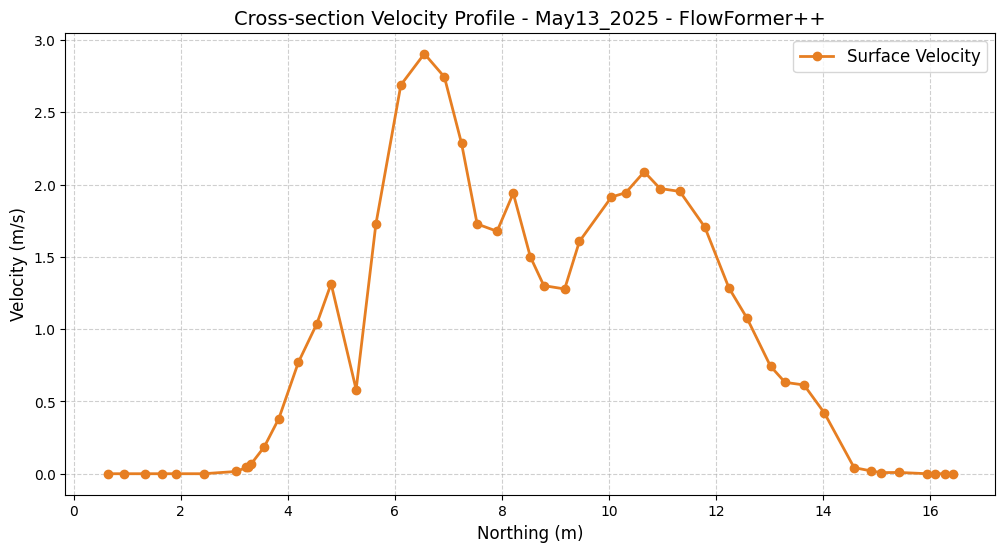

✅ Saved velocity profile plot: results/flowformer/FlowFormer++/May13_2025/May13_2025_velocity_profile.png

🎉 Velocity profile plotting complete!


In [6]:
# ========================================
# VELOCITY PROFILE PLOTTING (SIMPLE)
# -----------------------------
# This creates a plot for the model that was just processed
print("\n" + "="*60)
print("CREATING VELOCITY PROFILE PLOT")
print("="*60)

# Use the model name and output directory from earlier in the script
model_name = "FlowFormer++"  # This should match what you used above
csv_path = os.path.join(model_out_dir, f"{video_name}_cross_section_survey_points.csv")

print(f"Creating velocity profile for {model_name}...")
print(f"CSV file: {csv_path}")

if not os.path.exists(csv_path):
    print(f"❌ CSV not found: {csv_path}")
    print("   Make sure the main processing completed successfully.")
else:
    # Load the CSV
    out_df = pd.read_csv(csv_path)
    
    # Create the plot
    plt.figure(figsize=(12,6))
    plt.plot(out_df['Northing'], out_df['Velocity_m_s'], '-o', color='#e67e22', 
             linewidth=2, label='Surface Velocity')
    
    plt.xlabel("Northing (m)", fontsize=12)
    plt.ylabel("Velocity (m/s)", fontsize=12)
    plt.title(f"Cross-section Velocity Profile - {video_name} - {model_name}", 
              fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    
    # Save the plot
    plot_path = os.path.join(model_out_dir, f"{video_name}_velocity_profile.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved velocity profile plot: {plot_path}")

print("\n" + "="*60)
print("🎉 Velocity profile plotting complete!")
print("="*60)

### Discharge Estimation

Surface velocities are first converted to depth averaged velocities using a velocity conversion factor. A power law profile is then applied to correct the velocity distribution across the channel. These velocities are combined with surveyed bathymetry to compute both uncorrected and corrected discharge estimates.

# 3. Converting to mean velocity


CREATING MEAN VELOCITY PROFILE PLOTS
Looking for CSV at: results/flowformer/FlowFormer++/May13_2025/May13_2025_cross_section_survey_points.csv
📊 Creating mean velocity profile for FlowFormer++...
✅ Saved CSV with mean velocity: results/flowformer/FlowFormer++/May13_2025/May13_2025_cross_section_survey_points_mean_velocity.csv


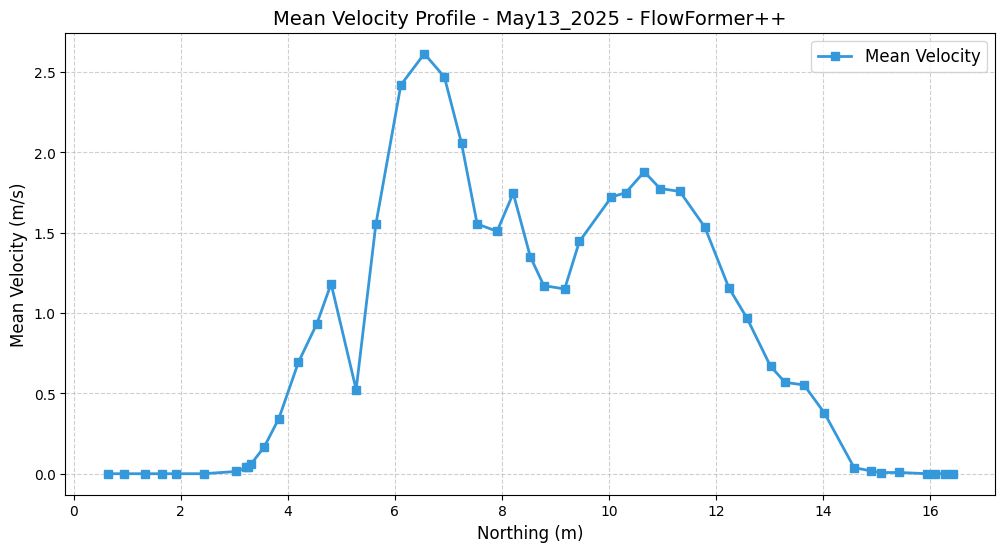

✅ Saved mean velocity profile plot: results/flowformer/FlowFormer++/May13_2025/May13_2025_mean_velocity_profile.png

🎉 Mean velocity conversion and plot completed!


In [8]:
# ========================================
# MEAN VELOCITY CONVERSION & PLOTTING
# -----------------------------
MEAN_VEL_FACTOR = 0.9  # (Change as per the site specification)

print("\n" + "="*60)
print("CREATING MEAN VELOCITY PROFILE PLOTS")
print("="*60)

# Process the current model's output
model_name = "FlowFormer++"  # This should match what you used above
csv_path = os.path.join(model_out_dir, f"{video_name}_cross_section_survey_points.csv")

print(f"Looking for CSV at: {csv_path}")

# Check if CSV exists (it should if the main loop completed)
if not os.path.exists(csv_path):
    print(f"❌ CSV not found: {csv_path}")
else:
    print(f"📊 Creating mean velocity profile for {model_name}...")
    
    # Load the CSV that was just created
    out_df = pd.read_csv(csv_path)
    
    # Convert to mean velocity
    out_df['MeanVelocity_m_s'] = out_df['Velocity_m_s'] * MEAN_VEL_FACTOR
    
    # Save new CSV with mean velocity
    mean_vel_csv_path = os.path.join(model_out_dir, f"{video_name}_cross_section_survey_points_mean_velocity.csv")
    out_df.to_csv(mean_vel_csv_path, index=False)
    print(f"✅ Saved CSV with mean velocity: {mean_vel_csv_path}")
    
    # -------------------------------
    # Plot mean velocity profile only
    # -------------------------------
    plt.figure(figsize=(12,6))
    plt.plot(out_df['Northing'], out_df['MeanVelocity_m_s'], '-s', color='#3498db', linewidth=2, label='Mean Velocity')
    
    plt.xlabel("Northing (m)", fontsize=12)
    plt.ylabel("Mean Velocity (m/s)", fontsize=12)
    plt.title(f"Mean Velocity Profile - {video_name} - {model_name}", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    
    # Save the plot
    plot_path = os.path.join(model_out_dir, f"{video_name}_mean_velocity_profile.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved mean velocity profile plot: {plot_path}")

print("\n🎉 Mean velocity conversion and plot completed!")
print("="*60)

# 4. Defining Bathymetry


BATHYMETRY ANALYSIS & WETTED WIDTH
Processing video: May13_2025
Stage: 0.588 m, Water level: 1.034 m (PT + stage)

📊 Processing FlowFormer++...
────────────────────────────────────────
Looking for mean velocity CSV at: results/flowformer/FlowFormer++/May13_2025/May13_2025_cross_section_survey_points_mean_velocity.csv
Lowest elevation: -2.714 m
Wetted width: 13.746 m
Left edge: 2.263 m, Right edge: 16.008 m


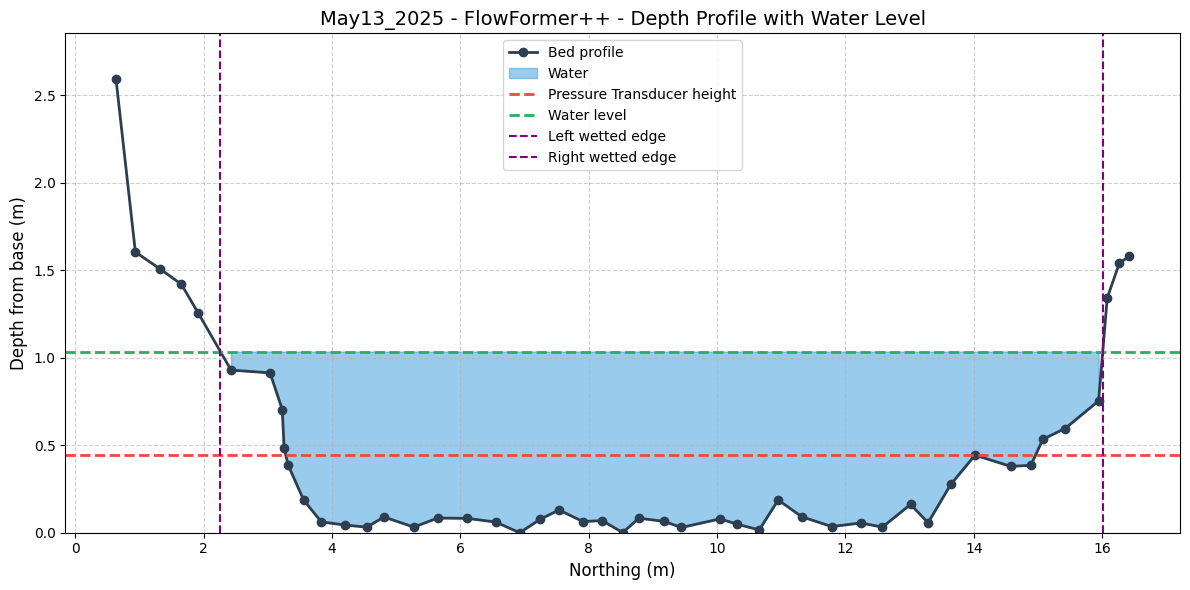

✅ Saved bathymetry plot: results/flowformer/FlowFormer++/May13_2025/May13_2025_depth_profile_with_water_level.png
✅ Saved bathymetry CSV: results/flowformer/FlowFormer++/May13_2025/May13_2025_bathymetry_analysis.csv

🎉 Bathymetry analysis completed!


In [10]:
# ========================================
# BATHYMETRY & WETTED WIDTH COMPUTATION
# -----------------------------
print("\n" + "="*60)
print("BATHYMETRY ANALYSIS & WETTED WIDTH")
print("="*60)

# Define stage for each video
video_stages = {
    "May13_2025":  58.83 / 100,   # Stage in meters (converted from cm)
}

PT_height = 0.446  # Pressure transducer height from base (m)

# Wetted width computation helper
def compute_wetted_width(x, z, water_level):
    below_mask = z <= water_level
    if not np.any(below_mask):
        return None, None, 0.0

    # Left intersection
    left_idx = np.where(below_mask)[0][0]
    if left_idx == 0:
        x_left = x[left_idx]
    else:
        x1, z1 = x[left_idx - 1], z[left_idx - 1]
        x2, z2 = x[left_idx], z[left_idx]
        x_left = x1 + (water_level - z1) * (x2 - x1) / (z2 - z1 + 1e-9)

    # Right intersection
    right_idx = np.where(below_mask)[0][-1]
    if right_idx == len(x) - 1:
        x_right = x[right_idx]
    else:
        x1, z1 = x[right_idx], z[right_idx]
        x2, z2 = x[right_idx + 1], z[right_idx + 1]
        x_right = x1 + (water_level - z1) * (x2 - x1) / (z2 - z1 + 1e-9)

    return x_left, x_right, x_right - x_left

# Get the video name
print(f"Processing video: {video_name}")

# Get stage for this video
stage = video_stages.get(video_name, 0.0)
water_level = PT_height + stage
print(f"Stage: {stage:.3f} m, Water level: {water_level:.3f} m (PT + stage)")

print(f"\n📊 Processing FlowFormer++...")
print(f"{'─' * 40}")

# Load the MEAN VELOCITY CSV from previous step
mean_vel_csv_path = os.path.join(model_out_dir, f"{video_name}_cross_section_survey_points_mean_velocity.csv")

print(f"Looking for mean velocity CSV at: {mean_vel_csv_path}")

if not os.path.exists(mean_vel_csv_path):
    print(f"❌ Mean velocity CSV not found: {mean_vel_csv_path}")
else:
    # Load the MEAN velocity data
    df = pd.read_csv(mean_vel_csv_path)
    
    # Normalize elevations to lowest point
    if 'Elevation' in df.columns:
        z_min = df['Elevation'].min()
        df['DepthFromBase_m'] = df['Elevation'] - z_min
        print(f"Lowest elevation: {z_min:.3f} m")
    elif 'DepthFromBase_m' in df.columns:
        print("DepthFromBase_m column already exists")
    else:
        print(f"❌ No elevation data found in CSV")
        
    # Compute wetted width
    x = df['Northing'].values
    z = df['DepthFromBase_m'].values
    x_left, x_right, wetted_width = compute_wetted_width(x, z, water_level)
    
    if x_left is not None and x_right is not None:
        df['WettedWidth_m'] = wetted_width
        df['WaterLevel_m'] = water_level
        df['LeftWettedEdge_m'] = x_left
        df['RightWettedEdge_m'] = x_right
        print(f"Wetted width: {wetted_width:.3f} m")
        print(f"Left edge: {x_left:.3f} m, Right edge: {x_right:.3f} m")
    else:
        print("⚠ No wetted area detected")
        
    # Plot cross-section
    plt.figure(figsize=(12,6))
    plt.plot(df['Northing'], df['DepthFromBase_m'], '-o', color='#2c3e50', linewidth=2, label='Bed profile')
    plt.fill_between(df['Northing'], df['DepthFromBase_m'], water_level,
                     where=(water_level > df['DepthFromBase_m']),
                     color='#3498db', alpha=0.5, label='Water')
    plt.axhline(y=PT_height, color='#e74c3c', linestyle='--', linewidth=2, label='Pressure Transducer height')
    plt.axhline(y=water_level, color='#27ae60', linestyle='--', linewidth=2, label='Water level')
    if x_left is not None:
        plt.axvline(x=x_left, color='purple', linestyle='--', label='Left wetted edge')
        plt.axvline(x=x_right, color='purple', linestyle='--', label='Right wetted edge')
    plt.xlabel("Northing (m)", fontsize=12)
    plt.ylabel("Depth from base (m)", fontsize=12)
    plt.title(f"{video_name} - FlowFormer++ - Depth Profile with Water Level", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=10)
    plt.ylim(0, max(df['DepthFromBase_m'].max(), water_level) * 1.1)
    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(model_out_dir, f"{video_name}_depth_profile_with_water_level.png")
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"✅ Saved bathymetry plot: {plot_path}")
    
    # Save updated CSV with bathymetry data
    bathymetry_csv_path = os.path.join(model_out_dir, f"{video_name}_bathymetry_analysis.csv")
    df.to_csv(bathymetry_csv_path, index=False)
    print(f"✅ Saved bathymetry CSV: {bathymetry_csv_path}")

print("\n🎉 Bathymetry analysis completed!")
print("="*60)

# 5. Applying Power-law for Corrected Velocity


APPLYING POWER LAW VELOCITY CORRECTION
Processing video: May13_2025
Looking for mean velocity CSV at: results/flowformer/FlowFormer++/May13_2025/May13_2025_cross_section_survey_points_mean_velocity.csv
📊 Applying power law correction for FlowFormer++...
  • Wetted width: 13.746 m
  • Max velocity: 2.615 m/s at x=6.551 m
  • Points corrected: 47.5% (threshold: 50.0%)
✅ Saved power law corrected CSV: results/flowformer/FlowFormer++/May13_2025/May13_2025_power_law_corrected.csv


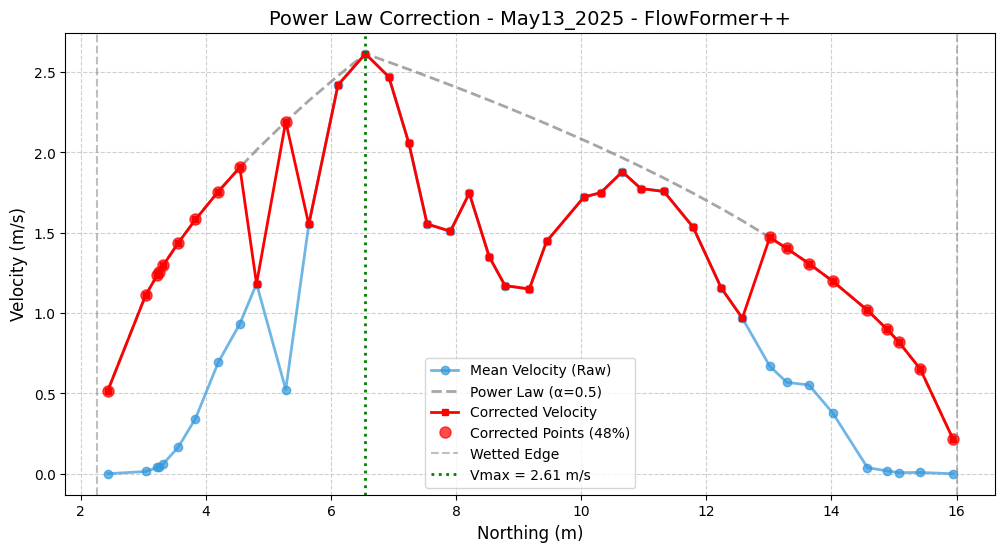

✅ Saved plot: results/flowformer/FlowFormer++/May13_2025/May13_2025_power_law_correction.png

🎉 Power law velocity correction completed!


In [12]:
# ========================================
# POWER LAW VELOCITY CORRECTION
# -----------------------------
ALPHA = 0.5                    # Power-law exponent
DEVIATION_THRESHOLD = 0.50     # 50% replacement rule

print("\n" + "="*60)
print("APPLYING POWER LAW VELOCITY CORRECTION")
print("="*60)

# Function: compute wetted edges
def compute_wetted_edges(northing, depth_from_base, water_level):
    below_mask = depth_from_base <= water_level
    if not np.any(below_mask):
        return northing.min(), northing.max(), 0.0

    # Left edge
    left_idx = np.where(below_mask)[0][0]
    if left_idx == 0:
        x_left = northing[left_idx]
    else:
        x1, z1 = northing[left_idx - 1], depth_from_base[left_idx - 1]
        x2, z2 = northing[left_idx], depth_from_base[left_idx]
        x_left = x1 + (water_level - z1) * (x2 - x1) / (z2 - z1 + 1e-9)

    # Right edge
    right_idx = np.where(below_mask)[0][-1]
    if right_idx == len(northing) - 1:
        x_right = northing[right_idx]
    else:
        x1, z1 = northing[right_idx], depth_from_base[right_idx]
        x2, z2 = northing[right_idx + 1], depth_from_base[right_idx + 1]
        x_right = x1 + (water_level - z1) * (x2 - x1) / (z2 - z1 + 1e-9)

    return x_left, x_right, x_right - x_left

print(f"Processing video: {video_name}")

# IMPORTANT: Use the MEAN VELOCITY CSV from previous step
# Path to MEAN VELOCITY CSV (from previous step)
mean_vel_csv_path = os.path.join(model_out_dir, f"{video_name}_cross_section_survey_points_mean_velocity.csv")

print(f"Looking for mean velocity CSV at: {mean_vel_csv_path}")

if not os.path.exists(mean_vel_csv_path):
    print(f"❌ Mean velocity CSV not found: {mean_vel_csv_path}")
else:
    print(f"📊 Applying power law correction for FlowFormer++...")
    
    # Load the MEAN velocity data
    df = pd.read_csv(mean_vel_csv_path)
    
    # Get data arrays - using MEAN velocity
    northing = df['Northing'].values
    velocity_mean = df['MeanVelocity_m_s'].values  # Using mean velocity!
    
    # We need depth_from_base - check if it exists
    if 'DepthFromBase_m' in df.columns:
        depth_from_base = df['DepthFromBase_m'].values
    else:
        # If not, we need to calculate from elevation data
        if 'Elevation' in df.columns:
            min_elevation = df['Elevation'].min()
            depth_from_base = df['Elevation'].values - min_elevation
            df['DepthFromBase_m'] = depth_from_base
        else:
            print(f"❌ No elevation or depth data found in CSV")
            
    # Compute wetted edges
    x_left, x_right, wetted_width = compute_wetted_edges(northing, depth_from_base, water_level)
    mask = (northing >= x_left) & (northing <= x_right)
    
    x = northing[mask]
    velocity_mean_masked = velocity_mean[mask]  # Using MEAN velocity
    
    if len(x) == 0:
        print(f"⚠ No points in wetted width")
    else:
        # Find Vmax location
        vmax_idx = np.argmax(velocity_mean_masked)
        Vmax = velocity_mean_masked[vmax_idx]
        x_vmax = x[vmax_idx]
        
        print(f"  • Wetted width: {wetted_width:.3f} m")
        print(f"  • Max velocity: {Vmax:.3f} m/s at x={x_vmax:.3f} m")
        
        # ---------------------------------------------
        # Compute Power Law profile
        # ---------------------------------------------
        epsilon = 1e-9
        u_power = np.zeros_like(x)
        
        for i, xi in enumerate(x):
            if xi <= x_vmax:
                u_power[i] = Vmax * ((xi - x_left) / (x_vmax - x_left + epsilon))**ALPHA
            else:
                u_power[i] = Vmax * ((x_right - xi) / (x_right - x_vmax + epsilon))**ALPHA
        
        # ---------------------------------------------
        # Correct velocities if deviation > threshold
        # ---------------------------------------------
        deviation = np.abs(velocity_mean_masked - u_power) / (u_power + epsilon)
        corrected = velocity_mean_masked.copy()
        correction_mask = deviation > DEVIATION_THRESHOLD
        corrected[correction_mask] = u_power[correction_mask]
        
        percent_corrected = (np.sum(correction_mask) / len(x)) * 100
        print(f"  • Points corrected: {percent_corrected:.1f}% (threshold: {DEVIATION_THRESHOLD*100}%)")
        
        # ---------------------------------------------
        # Save corrected profile
        # ---------------------------------------------
        df.loc[mask, 'Velocity_Corrected_Power'] = 0.0  # Initialize
        df.loc[mask, 'PowerLaw_Profile'] = u_power
        df.loc[mask, 'Velocity_Corrected_Power'] = corrected
        
        # Add correction flag
        df['Was_Corrected'] = False
        if mask.any():
            mask_indices = np.where(mask)[0]
            df.loc[mask_indices[correction_mask], 'Was_Corrected'] = True
        
        out_csv = os.path.join(model_out_dir, f"{video_name}_power_law_corrected.csv")
        df.to_csv(out_csv, index=False)
        print(f"✅ Saved power law corrected CSV: {out_csv}")
        
        # ---------------------------------------------
        # Plot comparison
        # ---------------------------------------------
        plt.figure(figsize=(12,6))
        
        # Plot raw mean velocity
        plt.plot(x, velocity_mean_masked, '-o', color='#3498db', linewidth=2, 
                 markersize=6, label='Mean Velocity (Raw)', alpha=0.7)
        
        # Plot power law profile
        plt.plot(x, u_power, '--', color='gray', linewidth=2, 
                 label=f'Power Law (α={ALPHA})', alpha=0.7)
        
        # Plot corrected velocity
        plt.plot(x, corrected, '-s', color='red', linewidth=2, 
                 markersize=5, label='Corrected Velocity')
        
        # Highlight corrected points
        if np.any(correction_mask):
            plt.plot(x[correction_mask], corrected[correction_mask], 'o',
                     color='red', markersize=8, alpha=0.7,
                     label=f'Corrected Points ({percent_corrected:.0f}%)')
        
        # Vertical lines
        plt.axvline(x_left, color='gray', linestyle='--', alpha=0.5, label='Wetted Edge')
        plt.axvline(x_right, color='gray', linestyle='--', alpha=0.5)
        plt.axvline(x_vmax, color='green', linestyle=':', linewidth=2, 
                    label=f'Vmax = {Vmax:.2f} m/s')
        
        plt.xlabel("Northing (m)", fontsize=12)
        plt.ylabel("Velocity (m/s)", fontsize=12)
        plt.title(f"Power Law Correction - {video_name} - FlowFormer++", fontsize=14)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=10)
        
        plot_path = os.path.join(model_out_dir, f"{video_name}_power_law_correction.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✅ Saved plot: {plot_path}")

print("\n🎉 Power law velocity correction completed!")
print("="*60)

# 6. Final Discharge


FINAL DISCHARGE CALCULATION & ERROR METRICS
Processing video: May13_2025
Ground truth discharge: 16.220 m³/s
📊 Loading power law corrected data: results/flowformer/FlowFormer++/May13_2025/May13_2025_power_law_corrected.csv
Water level: 1.034 m
Found 40 wetted points
Uncorrected discharge: 13.965 m³/s
Corrected discharge: 17.847 m³/s

DISCHARGE RESULTS & ERROR METRICS
Metric                    Uncorrected     Corrected       Improvement    
----------------------------------------------------------------------
Discharge (m³/s)          13.965          17.847          +3.881         
Error (m³/s)              -2.255          +1.627          +3.881         
Absolute Error (m³/s)     2.255           1.627           +0.628         
Percent Error (%)         13.90           10.03           +3.87%         
EPE (%)                   13.90           10.03           -3.87%         
Bias (m³/s)               -2.255          +1.627          +3.881         

SUMMARY
• Ground Truth: 16.220 m³/s
• R

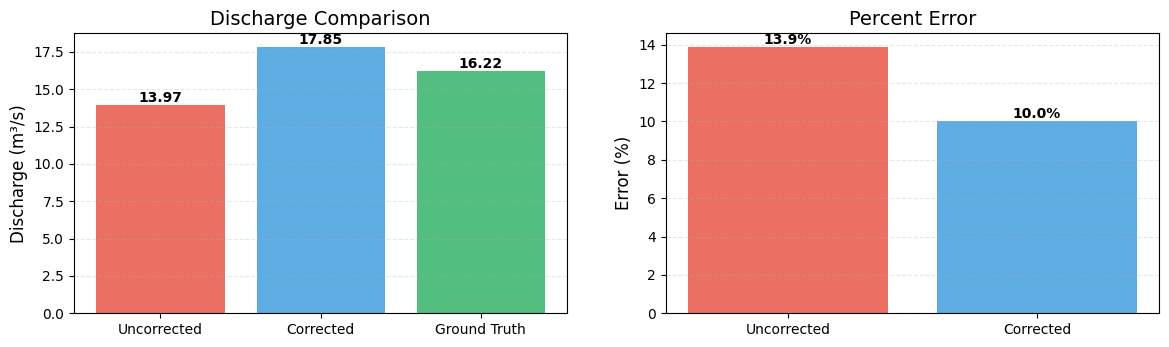

✅ Saved discharge analysis plot: discharge/FlowFormer++/May13_2025/May13_2025_discharge_analysis.png

DISCHARGE ANALYSIS COMPLETE! 🎉


In [13]:
# FINAL DISCHARGE CALCULATION & METRICS
# -----------------------------
print("\n" + "="*60)
print("FINAL DISCHARGE CALCULATION & ERROR METRICS")
print("="*60)

# Ground truth discharge value for this video
GROUND_TRUTH_DISCHARGE = 16.22  # m³/s (for May13_2025)

# Get the video name
original_video_name = os.path.splitext(os.path.basename(VIDEO_PATH))[0]
print(f"Processing video: {original_video_name}")
print(f"Ground truth discharge: {GROUND_TRUTH_DISCHARGE:.3f} m³/s")

# Only process MaskFlowNet
TARGET_MODEL = "FlowFormer++"

# Create discharge results folder
discharge_dir = os.path.join("discharge", TARGET_MODEL, original_video_name)
os.makedirs(discharge_dir, exist_ok=True)

# Load the power law corrected CSV from previous step
power_law_csv = os.path.join(OUT_ROOT, TARGET_MODEL, original_video_name, 
                             f"{original_video_name}_power_law_corrected.csv")

if not os.path.exists(power_law_csv):
    print(f"❌ Power law corrected CSV not found: {power_law_csv}")
    print("Please run the power law correction step first.")
else:
    print(f"📊 Loading power law corrected data: {power_law_csv}")
    df = pd.read_csv(power_law_csv)
    
    # Get water level from the data (should be saved in bathymetry step)
    if 'WaterLevel_m' in df.columns:
        water_level = df['WaterLevel_m'].iloc[0]
    else:
        # Fallback calculation
        stage = video_stages.get(original_video_name, 0.0)
        water_level = PT_height + stage
        df['WaterLevel_m'] = water_level
    
    print(f"Water level: {water_level:.3f} m")
    
    # Ensure we have depth data
    if 'DepthFromBase_m' not in df.columns and 'Elevation' in df.columns:
        z_min = df['Elevation'].min()
        df['DepthFromBase_m'] = df['Elevation'] - z_min
    
    # Calculate water depth at each point
    df['WaterDepth_m'] = np.maximum(0, water_level - df['DepthFromBase_m'])
    
    # Calculate distance between consecutive points (width segments)
    df['SegmentWidth_m'] = np.abs(df['Northing'].diff())
    df.loc[0, 'SegmentWidth_m'] = 0  # First point has no width
    
    # Only consider wetted points
    wetted_mask = df['WaterDepth_m'] > 0
    wetted_df = df[wetted_mask].copy()
    
    if len(wetted_df) < 2:
        print("⚠ Not enough wetted points for discharge calculation")
    else:
        print(f"Found {len(wetted_df)} wetted points")
        
        # --------------------------------------------------
        # 1. Uncorrected DISCHARGE (using mean velocity)
        # --------------------------------------------------
        if 'MeanVelocity_m_s' in wetted_df.columns:
            # Calculate segment areas and velocities
            depths = wetted_df['WaterDepth_m'].values
            widths = wetted_df['SegmentWidth_m'].values
            raw_vel = wetted_df['MeanVelocity_m_s'].values
            
            # Trapezoidal integration
            Q_raw_total = 0.0
            raw_segment_Q = []
            
            for i in range(len(wetted_df) - 1):
                avg_depth = (depths[i] + depths[i+1]) / 2
                avg_velocity = (raw_vel[i] + raw_vel[i+1]) / 2
                segment_width = widths[i+1]  # Use forward width
                segment_Q = avg_velocity * avg_depth * segment_width
                raw_segment_Q.append(segment_Q)
                Q_raw_total += segment_Q
            
            wetted_df['RawSegmentDischarge_m3s'] = np.append(raw_segment_Q, 0)
            print(f"Uncorrected discharge: {Q_raw_total:.3f} m³/s")
        
        # --------------------------------------------------
        # 2. CORRECTED DISCHARGE (using power law corrected velocity)
        # --------------------------------------------------
        if 'Velocity_Corrected_Power' in wetted_df.columns:
            # Calculate segment areas and velocities
            depths = wetted_df['WaterDepth_m'].values
            widths = wetted_df['SegmentWidth_m'].values
            corrected_vel = wetted_df['Velocity_Corrected_Power'].values
            
            # Trapezoidal integration
            Q_corrected_total = 0.0
            corrected_segment_Q = []
            
            for i in range(len(wetted_df) - 1):
                avg_depth = (depths[i] + depths[i+1]) / 2
                avg_velocity = (corrected_vel[i] + corrected_vel[i+1]) / 2
                segment_width = widths[i+1]  # Use forward width
                segment_Q = avg_velocity * avg_depth * segment_width
                corrected_segment_Q.append(segment_Q)
                Q_corrected_total += segment_Q
            
            wetted_df['CorrectedSegmentDischarge_m3s'] = np.append(corrected_segment_Q, 0)
            print(f"Corrected discharge: {Q_corrected_total:.3f} m³/s")
        
        # --------------------------------------------------
        # 3. CALCULATE ERROR METRICS
        # --------------------------------------------------
        if 'MeanVelocity_m_s' in wetted_df.columns and 'Velocity_Corrected_Power' in wetted_df.columns:
            # Calculate errors
            raw_error = Q_raw_total - GROUND_TRUTH_DISCHARGE
            corrected_error = Q_corrected_total - GROUND_TRUTH_DISCHARGE
            
            # Absolute errors
            raw_abs_error = abs(raw_error)
            corrected_abs_error = abs(corrected_error)
            
            # Percent errors
            raw_percent_error = (raw_abs_error / GROUND_TRUTH_DISCHARGE) * 100
            corrected_percent_error = (corrected_abs_error / GROUND_TRUTH_DISCHARGE) * 100
            
            # Error Percentage Estimate (EPE) - similar to MAPE but different name
            raw_EPE = raw_percent_error  # EPE = percent error for single measurement
            corrected_EPE = corrected_percent_error
            
            # Bias (mean error)
            raw_bias = raw_error
            corrected_bias = corrected_error
            
            # Error reduction
            error_reduction_abs = raw_abs_error - corrected_abs_error
            error_reduction_percent = raw_percent_error - corrected_percent_error
            
            # --------------------------------------------------
            # 4. CREATE METRICS DATAFRAME
            # --------------------------------------------------
            metrics_data = {
                'Metric': [
                    'Discharge (m³/s)',
                    'Error (m³/s)',
                    'Absolute Error (m³/s)',
                    'Percent Error (%)',
                    'EPE (%)',
                    'Bias (m³/s)'
                ],
                'Uncorrected': [
                    f"{Q_raw_total:.3f}",
                    f"{raw_error:+.3f}",
                    f"{raw_abs_error:.3f}",
                    f"{raw_percent_error:.2f}",
                    f"{raw_EPE:.2f}",
                    f"{raw_bias:+.3f}"
                ],
                'Corrected': [
                    f"{Q_corrected_total:.3f}",
                    f"{corrected_error:+.3f}",
                    f"{corrected_abs_error:.3f}",
                    f"{corrected_percent_error:.2f}",
                    f"{corrected_EPE:.2f}",
                    f"{corrected_bias:+.3f}"
                ],
                'Improvement': [
                    f"{Q_corrected_total - Q_raw_total:+.3f}",
                    f"{corrected_error - raw_error:+.3f}",
                    f"{error_reduction_abs:+.3f}",
                    f"{error_reduction_percent:+.2f}%",
                    f"{corrected_EPE - raw_EPE:+.2f}%",
                    f"{corrected_bias - raw_bias:+.3f}"
                ]
            }
            
            metrics_df = pd.DataFrame(metrics_data)
            
            # --------------------------------------------------
            # 5. DISPLAY RESULTS
            # --------------------------------------------------
            print("\n" + "="*60)
            print("DISCHARGE RESULTS & ERROR METRICS")
            print("="*60)
            print(f"{'Metric':<25} {'Uncorrected':<15} {'Corrected':<15} {'Improvement':<15}")
            print("-" * 70)
            
            for _, row in metrics_df.iterrows():
                print(f"{row['Metric']:<25} {row['Uncorrected']:<15} {row['Corrected']:<15} {row['Improvement']:<15}")
            
            print("\n" + "="*60)
            print("SUMMARY")
            print("="*60)
            print(f"• Ground Truth: {GROUND_TRUTH_DISCHARGE:.3f} m³/s")
            print(f"• Raw Discharge Error: {raw_error:+.3f} m³/s ({raw_percent_error:.1f}%)")
            print(f"• Corrected Discharge Error: {corrected_error:+.3f} m³/s ({corrected_percent_error:.1f}%)")
            print(f"• Error Reduction: {error_reduction_abs:+.3f} m³/s ({error_reduction_percent:+.1f}%)")
            
            # --------------------------------------------------
            # 6. SAVE ALL RESULTS
            # --------------------------------------------------
            # Save detailed wetted section data
            detailed_csv = os.path.join(discharge_dir, f"{original_video_name}_discharge_detailed.csv")
            wetted_df.to_csv(detailed_csv, index=False)
            print(f"\n✅ Saved detailed discharge data: {detailed_csv}")
            
            # Save metrics
            metrics_csv = os.path.join(discharge_dir, f"{original_video_name}_discharge_metrics.csv")
            metrics_df.to_csv(metrics_csv, index=False)
            print(f"✅ Saved error metrics: {metrics_csv}")
            
            # Save summary as text file
            summary_txt = os.path.join(discharge_dir, f"{original_video_name}_discharge_summary.txt")
            with open(summary_txt, 'w') as f:
                f.write("="*60 + "\n")
                f.write("DISCHARGE CALCULATION SUMMARY\n")
                f.write("="*60 + "\n\n")
                f.write(f"Video: {original_video_name}\n")
                f.write(f"Model: {TARGET_MODEL}\n")
                f.write(f"Ground Truth Discharge: {GROUND_TRUTH_DISCHARGE:.3f} m³/s\n\n")
                
                f.write("="*60 + "\n")
                f.write("DISCHARGE RESULTS\n")
                f.write("="*60 + "\n")
                f.write(f"{'Metric':<25} {'Raw':<15} {'Corrected':<15} {'Improvement':<15}\n")
                f.write("-" * 70 + "\n")
                
                for _, row in metrics_df.iterrows():
                    f.write(f"{row['Metric']:<25} {row['Uncorrected']:<15} {row['Corrected']:<15} {row['Improvement']:<15}\n")
                
                f.write("\n" + "="*60 + "\n")
                f.write("KEY FINDINGS\n")
                f.write("="*60 + "\n")
                f.write(f"• Raw discharge: {Q_raw_total:.3f} m³/s (Error: {raw_error:+.3f} m³/s)\n")
                f.write(f"• Corrected discharge: {Q_corrected_total:.3f} m³/s (Error: {corrected_error:+.3f} m³/s)\n")
                f.write(f"• Absolute error reduction: {error_reduction_abs:+.3f} m³/s\n")
                f.write(f"• Percent error reduction: {error_reduction_percent:+.1f}%\n")
                f.write(f"• Power law correction improved accuracy by {error_reduction_percent:.1f}%\n")
            
            print(f"✅ Saved summary text file: {summary_txt}")
            
            # --------------------------------------------------
            # 7. CREATE VISUALIZATION
            # --------------------------------------------------
            plt.figure(figsize=(14, 8))
            
            # Subplot 1: Discharge comparison
            ax1 = plt.subplot(2, 2, 1)
            methods = ['Uncorrected', 'Corrected', 'Ground Truth']
            values = [Q_raw_total, Q_corrected_total, GROUND_TRUTH_DISCHARGE]
            colors = ['#e74c3c', '#3498db', '#27ae60']
            
            bars = ax1.bar(methods, values, color=colors, alpha=0.8)
            ax1.set_ylabel('Discharge (m³/s)', fontsize=12)
            ax1.set_title('Discharge Comparison', fontsize=14)
            ax1.grid(True, linestyle='--', alpha=0.3, axis='y')
            
            # Add values on bars
            for bar, value in zip(bars, values):
                height = bar.get_height()
                ax1.text(bar.get_x() + bar.get_width()/2., height,
                        f'{value:.2f}', ha='center', va='bottom', fontweight='bold')
            
            # Subplot 2: Percent error
            ax3 = plt.subplot(2, 2, 2)
            percent_errors = [raw_percent_error, corrected_percent_error]
            percent_bars = ax3.bar(['Uncorrected', 'Corrected'], percent_errors,
                                  color=['#e74c3c', '#3498db'], alpha=0.8)
            ax3.set_ylabel('Error (%)', fontsize=12)
            ax3.set_title('Percent Error', fontsize=14)
            ax3.grid(True, linestyle='--', alpha=0.3, axis='y')
            
            # Add percent values
            for bar, pct in zip(percent_bars, percent_errors):
                height = bar.get_height()
                ax3.text(bar.get_x() + bar.get_width()/2., height,
                        f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold')
            
            # Save plot
            plot_path = os.path.join(discharge_dir, f"{original_video_name}_discharge_analysis.png")
            plt.savefig(plot_path, dpi=300, bbox_inches='tight')
            plt.show()
            print(f"✅ Saved discharge analysis plot: {plot_path}")

print("\n" + "="*60)
print("DISCHARGE ANALYSIS COMPLETE! 🎉")
print("="*60)